In [2]:
# Library 'datasets' needs to be installed separately while using Google Colab
!pip install datasets
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.3 MB/s eta 0:00:00


In [4]:
# Importing all required libraries
import sys
import gc
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm.auto import tqdm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from transformers import PreTrainedTokenizerFast
from transformers import pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [5]:
# Importing data
with open('final_data.json') as f:
    data = json.load(f)

In [6]:
# Converting the data into a dataframe and assigning a column name for the text data
df1 = pd.DataFrame(data)
df1 = df1.rename(columns={'0': "file"})

In [7]:
# Assigning labels to the data, the first 100 files are AI generated, and the next 100 are human written.
df1 = df1.assign(label=1)
for i in range(400,800):
    df1.label[i] = 0
df = df1.reindex()
df.reset_index(drop=True, inplace=True)

<ipython-input-7-ae398b01192e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.label[i] = 0


In [8]:
# Setting configuration parameters
LOWERCASE = False
VOCAB_SIZE = 30522

In [9]:
# Creating Tokenizer, Normalizing and Pre-Tokenizing
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

In [10]:
# Configuring BPE Trainer
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

In [11]:
# Splitting the dataset into training and testing sets
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
# Training the tokenizer
dataset = Dataset.from_pandas(X_test[['file']])
def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["file"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

In [13]:
# Creating PreTrained Tokenizer object using the trained raw tokenizer
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [14]:
# Tokenizing Testing and Training data
tokenized_texts_test = []
for text in tqdm(X_test['file'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))

tokenized_texts_train = []
for text in tqdm(X_train['file'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [15]:
# TF-IDF Vectorizer Configuration and Fitting on Test Data
def dummy(text):
    return text
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, strip_accents='unicode')
vectorizer.fit(tokenized_texts_test)

TfidfVectorizer(lowercase=False, ngram_range=(3, 5),
                preprocessor=<function dummy at 0x78072298e200>,
                strip_accents='unicode', sublinear_tf=True, token_pattern=None,
                tokenizer=<function dummy at 0x78072298e200>)

In [16]:
# Getting vocab
vocab = vectorizer.vocabulary_

In [17]:
# Reconfiguring Vectorizer and transforming training dataset, and testing dataset
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode'
                            )

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

In [24]:
# Model configuration and training
clf = MultinomialNB(alpha=0.005)
sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber")
p6 = {'n_iter': 2, 'verbose': -1, 'objective': 'cross_entropy', 'metric': 'auc',
          'learning_rate': 0.05073909898961407, 'colsample_bytree': 0.726023996436955,
          'colsample_bynode': 0.5803681307354022, 'lambda_l1': 8.562963348932286,
          'lambda_l2': 4.893256185259296, 'min_data_in_leaf': 115, 'max_depth': 23, 'max_bin': 898}
lgb = LGBMClassifier(**p6)
cat = CatBoostClassifier(iterations=2,
                             verbose=0,
                             l2_leaf_reg=6.6591278779517808,
                             learning_rate=0.005689066836106983,
                             subsample=0.4,
                             allow_const_label=True, loss_function='CrossEntropy')

weights = [0.4, 0.3,0.15,0.15]
ensemble = VotingClassifier(estimators=[('mnb', clf),
                                          ('sgd', sgd_model),
                                           ('lgb', lgb),
                                            ('cat', cat)],
                              weights=weights, voting='soft', n_jobs=-1)
ensemble.fit(tf_train, y_train)
gc.collect()

31

model 1 AUC score: 0.9619347739095638


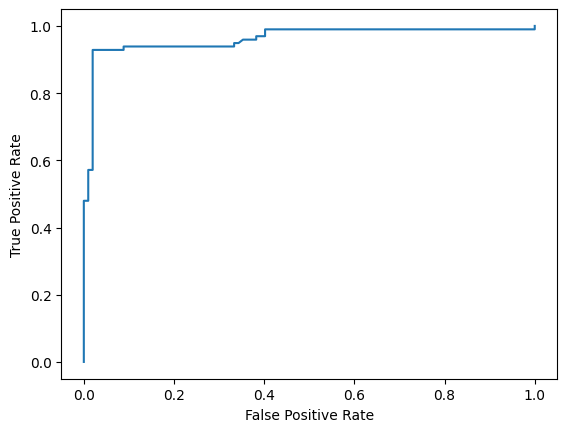

In [25]:
# Getting and formatiing predictions on test data
final_preds = ensemble.predict_proba(tf_test)[:, 1]
formatted_values = [f"{val:f}" for val in final_preds]
# Plottin the roc curve based of the probabilities
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(y_test.to_numpy(), np.array(formatted_values).astype(float))
print(f'model 1 AUC score: {roc_auc_score(y_test.to_numpy(), np.array(formatted_values).astype(float))}')
floored_values = []
for val in formatted_values:
  if float(val)<0.65:
    floored_values.append(0)
  else:
    floored_values.append(1)

In [26]:
# Compute precision, recall, and F1 score for class 0
test_labels = y_test.tolist()
cm = confusion_matrix(test_labels, floored_values)
precision_0 = precision_score(test_labels, floored_values, pos_label=0)
recall_0 = recall_score(test_labels, floored_values, pos_label=0)
f1_0 = f1_score(test_labels, floored_values, pos_label=0)

# Compute precision, recall, and F1 score for class 1
precision_1 = precision_score(test_labels, floored_values, pos_label=1)
recall_1 = recall_score(test_labels, floored_values, pos_label=1)
f1_1 = f1_score(test_labels, floored_values, pos_label=1)

print("Confusion Matrix:")
print(cm)
print("\nClass 0:")
print("Precision:", precision_0)
print("Recall:", recall_0)
print("F1 Score:", f1_0)
print("\nClass 1:")
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1 Score:", f1_1)

Confusion Matrix:
[[100   2]
 [  7  91]]

Class 0:
Precision: 0.9345794392523364
Recall: 0.9803921568627451
F1 Score: 0.9569377990430622

Class 1:
Precision: 0.978494623655914
Recall: 0.9285714285714286
F1 Score: 0.9528795811518325


In [27]:
def classification(value):
  k = tokenizer.tokenize(value)
  t=[]
  t.append(k)
  t_test = vectorizer.transform(t)
  fin = ensemble.predict_proba(t_test)[:, 1]
  if float(fin)<0.65:
    val = 0
  else:
    val = 1
  return [fin[0],val]

In [38]:
#v12 = "In the United States District Court for the District of Columbia, the case between the United States of America and Derrek K. Arrington (Case No. 00-cr-159-RCL) has been under review . Mr. Arrington, the defendant, filed a motion to vacate his previous sentence under 28 U.S.C. § 2255. He had initially been given a twenty-year sentence after being found guilty by a jury of assaulting a federal officer with a dangerous weapon (18 U.S.C. § 111(a) and (b)) and illegal possession of a firearm as a convicted felon (18 U.S.C. §§ 922(g) and 924(a)(2)). This court, however , had decided to dismiss his appeal due to its untimely nature under 28 U.S.C. § 2255(f)(3) (United States v. Arrington, No. 00-cr-159 (RCL), 2019 WL 4644381, at *3–4 (D.D.C. Sept. 24, 2019), rev’d, 4 F.4th 162 (D.C. Cir. 2021)). The D.C. Circuit Court had overturned this decision and sent it back for further processing which resulted in the court deciding to grant Mr. Arrington's motion under § 2255, and his sentence was vacated. The court has also decided to resentence him at a future date. Background The root cause of Mr. Arrington's convictions was a traffic violation which escalated into a high-speed pursuit and culminated in him shooting a police officer in the face. On April 13, 2000, officers from the United States Park Police pulled over Mr. Arrington after noticing suspected drugs in his car. However , Mr. Arrington refused to exit his vehicle and instead attempted to speed away . Two officers tried to stop him but were unable to do so. One officer, Officer Daniels, was dragged through an intersection as Mr. Arrington attempted to escape. The pursuit ended when Mr. Arrington fled on foot, but not before shooting Officer Daniels in the face, causing significant facial paralysis and necessitating nerve surgery . Mr. Arrington was indicted on several felony charges and the case went to trial before Judge James Robertson. On September 18, 2000, the jury convicted Mr. Arrington of assaulting a federal officer with a dangerous weapon (18 U.S.C. § 111(a) and (b)) and unlawfully having a firearm as a convicted felon (18 U.S.C. §§ 922(g) and 924(a)(2)). However , the jury could not agree on the remaining charges. Given his previous convictions for two armed robbery offenses, Mr. Arrington was eligible for a heightened sentence of 210 to 262 months. However , due to the 10-year statutory maximum on his counts, the sentencing range was reduced to 210 to 240 months. The court considered his previous convictions for armed robbery as crimes of violence under the guidelines, leading to certain enhancements. At the time, the court had to adhere strictly to the sentencing guidelines (United States v. Booker , 543 U.S. 220, 233 (2005)). Eventually , Mr. Arrington was given a sentence of 240 months, the maximum under the guidelines. Further , as described by the Circuit in its reversal and remand opinion, Mr. Arrington's increased sentencing range was due to two guidelines provisions. The first, § 2K2.1(a), increased the base offense level for a defendant who had at least two prior felony convictions of either a violent crime or a controlled substance offense (U.S.S.G. § 2K2.1(a)(2) (Nov . 2000)). The second provision, § 4B1.1, classified a defendant as a career offender and imposed sentencing enhancements if three conditions were satisfied: 1) the defendant was at least eighteen years old at the time of the offense, 2) the offense was either a violent crime or a controlled substance offense, and 3) the defendant had at least two prior felony convictions of either a violent crime or a controlled substance offense (U.S.S.G. § 4B1.1(a) (Nov . 2000))."

In [39]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [53]:
def summarization(value):
  summ = summarizer(value, max_length=130, min_length=30, do_sample=False)
  return summ[0]['summary_text']

In [54]:
#v1 = summarization(v12)

In [55]:
#print(v1)

Derrek K. Arrington was convicted of assaulting a federal officer with a dangerous weapon and illegal possession of a firearm as a convicted felon. He shot a police officer in the face, causing significant facial paralysis and necessitating nerve surgery. Given his previous convictions for two armed robbery offenses, he was eligible for a heightened sentence of 210 to 262 months. Due to the 10-year statutory maximum on his counts, the sentencing range was reduced to 210 to 240 months.
